# CNN Classifier for fashion_MNIST

This notebook implements a convolutional neural net to perform classification on the CIFAR10 dataset using PyTorch. It is meant as an illustrative example and a way to test an installation of CUDA and PyTorch.

At the time of this writing, the targeted versions are:
 - Python 3.5.2
 - PyTorch 0.4.1
 - CUDA 9.2
 - CuDNN 7.2

In [1]:
%matplotlib notebook
import sys
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [2]:
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type
print(sys.version)
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.__version__)
print(torch.cuda.get_device_capability(0))

3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]
True
0
4
0.4.1
(6, 1)


In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig, ax = plt.subplots()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
N = 50

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=N, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=N, shuffle=True)

classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

print("{} training samples.".format(len(trainset)))
print("{} test samples.".format(len(testset)))

60000 training samples.
10000 test samples.


<IPython.core.display.Javascript object>


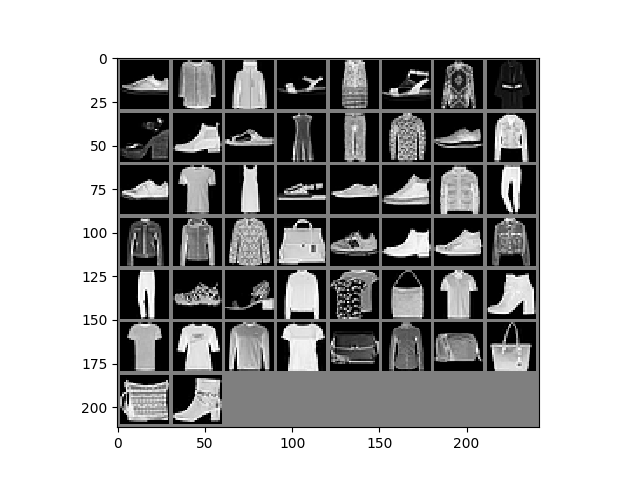

Sneaker Shirt  Coat Sandal


In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define the Neural Net

For this scenario, we want to start with something basic, but still functional.

Conv --> Pool --> Conv --> FC --> FC --> FC

Each convolutional layer uses 5x5 kernels. The fully connected layers scale down from 400 to 120 to 84, finally to our 10 classses.

We will use cross entropy as our loss function and reLU for activation functions.

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 12, 3, stride=2, padding=1)
        self.conv2_bn = nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12, 12, 3, padding=1)
        self.conv4 = nn.Conv2d(12, 24, 3, stride=2, padding=1)
        self.conv4_bn = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 24 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [12]:
net = Net()
print(net)
# move the net to the GPU
net.cuda()

criterion = nn.CrossEntropyLoss()
# criterion.cuda()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_loss = []
x_data = []
test_loss = []
test_x_data = []


Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=1176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# Training



<IPython.core.display.Javascript object>


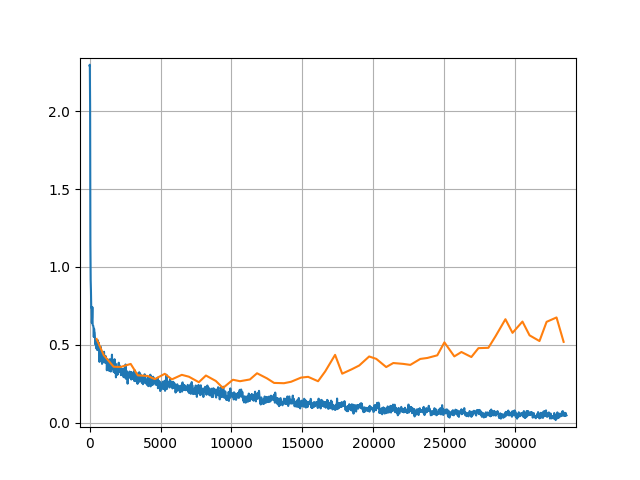


Finished Training


In [15]:
num_epochs = 20
loss_subsample = 20
plot_subsample = 200
test_subsample = 500
test_ratio = 0.2 # how much of the test set to we want to run each time we calculate

fig, ax = plt.subplots()
ax.autoscale()
ax.grid(True)


train_line, = ax.plot(x_data, train_loss)
test_line, = ax.plot(test_x_data, test_loss)
fig.canvas.draw()

for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0), total=len(trainset)//N):
        # get the inputs
        inputs, labels = data
        # put the data on the GPU
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # plot train loss
        running_loss += loss.item()
        if i == 0 and len(x_data) == 0:
            x_data += [i]
            train_loss += [running_loss]
        if i % loss_subsample == loss_subsample-1:
            x_data += [x_data[-1] + loss_subsample]
            train_loss += [running_loss / loss_subsample]
            running_loss = 0.0
        # print statistics
        if i % plot_subsample == plot_subsample-1:    # print every 2000 mini-batches
            train_line.set_xdata(x_data)
            train_line.set_ydata(train_loss)
            dx = x_data[-1]*0.02
            ax.set_xlim(0-dx, x_data[-1]+dx)
            dy = (max(train_loss) - min(train_loss))*0.02
            ax.set_ylim(min(train_loss)-dy, max(train_loss)+dy)
            fig.canvas.draw()
            fig.canvas.flush_events()
            
        # calculate test loss
        if i % test_subsample == test_subsample-1:
            testiter = iter(testloader)
            num_test_minibatches = int(len(testset)/N * test_ratio)
            running_loss_test = 0.0
            for j in range(num_test_minibatches):
                inputs, labels = testiter.next()
                # put the data on the GPU
                inputs = inputs.cuda()
                labels = labels.cuda()

                # forward pass only
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_loss_test += loss.item()
            test_loss += [running_loss_test / num_test_minibatches]
            
            # plot test loss
#             if i == 0:
            if len(test_x_data) == 0:
                test_x_data += [i]
            else:
                test_x_data += [x_data[-1]]
#                 test_x_data += [test_x_data[-1] + test_subsample]
            test_line.set_xdata(test_x_data)
            test_line.set_ydata(test_loss)
            fig.canvas.draw()
            fig.canvas.flush_events()

print('Finished Training')


# Test Results

Now that we have finished training the network, let's see how well it does on the images it hasn't trained on.

In [1]:
running_loss = 0.0
running_correct = 0.
minibatches = len(testset)//N
for i, data in tqdm(enumerate(testloader, 0), total=minibatches):
    # get the inputs
    inputs, labels = data
    # put the data on the GPU
    inputs = inputs.cuda()
    labels = labels.cuda()

    # forward pass only
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    # find the chosen label
    probs, y = outputs.max(1)
    correct = labels.eq(y).sum()

    # print statistics
    running_loss += loss.item()
    running_correct += correct
#     print(running_correct)
###
    
final_loss = running_loss / minibatches
final_accuracy = running_correct.float() / len(testset)

print("Test loss: {}".format(final_loss))
print("Test accuracy: {:.1f}%".format(final_accuracy*100))

NameError: name 'testset' is not defined

Well, 63% is pretty bad. We could have done better by applying a few of the recent techniques in deep learning such as:

- whitening the data
- going deeper (more layers)
- Xavier initialization
- batch normalization

We will apply more of these in other notebooks.

## Let's see it in action

Enough numbers and plots, let's see what this thing can do. First, we'll grab some data from the test set, then run it through our net. The outputs are log probabilities, so lets find the networks best guess by grabbing the max.

We can compare the outputs to the input images and true labels to see how it did.

<IPython.core.display.Javascript object>


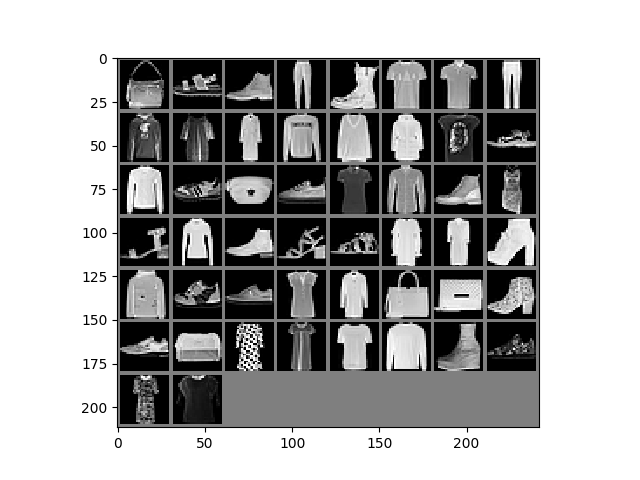

y=Bag, truth=Bag
y=Sandal, truth=Sandal
y=Ankle boot, truth=Ankle boot
y=Trouser, truth=Trouser
y=Ankle boot, truth=Ankle boot
y=T-shirt, truth=T-shirt
y=T-shirt, truth=T-shirt
y=Trouser, truth=Trouser
y=Pullover, truth=Pullover
y=Dress, truth=Dress


In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# run through network to see result
images = images.cuda()
outputs = net(images)
probs, y = outputs.max(1)
for j in range(10):
    print("y={}, truth={}".format(classes[y[j]], classes[labels[j]]))